<a href="https://colab.research.google.com/github/elichen/nematode/blob/main/nematode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, Image
from tqdm.notebook import tqdm
import random

In [2]:
grid_size = 40
num_pellets = 5
simulate_frames = 100

In [3]:
class WormEnvironment:
    def __init__(self, grid_size, num_pellets, controller):
        self.grid_size = grid_size
        self.num_pellets = num_pellets
        self.controller = controller
        self.reset_environment()

    def reset_environment(self):
        self.worm_position = (random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1))
        self.pellet_positions = [(random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)) for _ in range(self.num_pellets)]
        self.score = 0

    def calculate_local_gradient(self):
        """Calculate the chemical concentration gradient in the immediate vicinity of the worm."""
        x, y = self.worm_position
        local_gradient = {}

        # Consider only the immediate surroundings: up, down, left, and right
        for dx, dy in [(0, -1), (0, 1), (-1, 0), (1, 0)]:  # Directions: Up, Down, Left, Right
            adjacent_x, adjacent_y = x + dx, y + dy

            # Check bounds
            if 0 <= adjacent_x < self.grid_size and 0 <= adjacent_y < self.grid_size:
                gradient_value = 0
                for pellet in self.pellet_positions:
                    distance = np.sqrt((pellet[0] - adjacent_x) ** 2 + (pellet[1] - adjacent_y) ** 2)
                    gradient_value += max(0, 1 / (1 + distance))  # Simplified gradient calculation
                local_gradient[(dx, dy)] = gradient_value

        return local_gradient

    def update(self):
        """Update the environment state based on the worm's decision to move based on local gradients."""
        local_gradient = self.calculate_local_gradient()
        move_direction = self.controller.decide_move(local_gradient)
        new_position = (min(max(self.worm_position[0] + move_direction[0], 0), self.grid_size-1),
                        min(max(self.worm_position[1] + move_direction[1], 0), self.grid_size-1))
        self.worm_position = new_position
        if self.worm_position in self.pellet_positions:
            self.pellet_positions.remove(self.worm_position)
            self.score += 1
        return self.worm_position, self.pellet_positions, self.score

    def draw(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        grid[self.worm_position] = -1  # Worm's position
        for pellet in self.pellet_positions:
            grid[pellet] = 1  # Pellet's position
        return grid

In [4]:
class HeuristicController:
    def decide_move(self, local_gradient):
        # Find the direction with the highest gradient value
        max_gradient = -float('inf')
        move_direction = (0, 0)
        for direction, gradient_value in local_gradient.items():
            if gradient_value > max_gradient:
                max_gradient = gradient_value
                move_direction = direction

        return move_direction

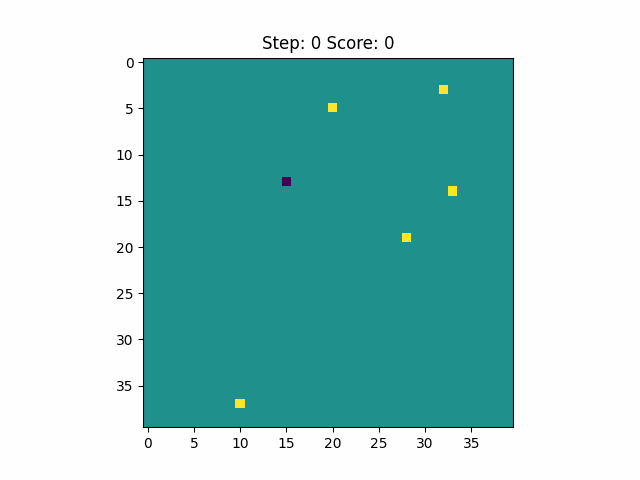

In [5]:
fig, ax = plt.subplots()
environment = WormEnvironment(grid_size, num_pellets, HeuristicController())

def animate(i):
    ax.clear()
    position, pellets, score = environment.update()
    grid = environment.draw()
    ax.imshow(grid, cmap='viridis')
    ax.set_title(f'Step: {i} Score: {score}')
    return ax

ani = animation.FuncAnimation(fig, animate, frames=simulate_frames, interval=100, blit=False, repeat=False)

ani.save('HeuristicController.gif', writer='pillow', fps=10)
plt.close(fig)
Image(filename='HeuristicController.gif')

In [6]:
inputs = []
outputs = []

environment = WormEnvironment(grid_size, num_pellets, HeuristicController())
for _ in range(100000):
    # Reset the environment to a random state for each instance
    environment.reset_environment()

    # Calculate the local gradient around the worm
    local_gradient = environment.calculate_local_gradient()

    # Create input feature vector from the local gradients
    input_features = [local_gradient.get((0, -1), 0),  # Gradient Up
                      local_gradient.get((0, 1), 0),   # Gradient Down
                      local_gradient.get((-1, 0), 0),  # Gradient Left
                      local_gradient.get((1, 0), 0)]   # Gradient Right
    inputs.append(input_features)

    # Use HeuristicController to determine the optimal move direction
    heuristic_move = environment.controller.decide_move(local_gradient)
    output_label = [(0, -1) == heuristic_move,  # Up
                    (0, 1) == heuristic_move,   # Down
                    (-1, 0) == heuristic_move,  # Left
                    (1, 0) == heuristic_move]   # Right
    outputs.append(output_label)

In [7]:
class NeuralController(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralController, self).__init__()
        # Define the architecture of the neural network
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),  # Input layer to hidden layer
            nn.ReLU(),  # Activation function
            nn.Linear(128, output_size),  # Hidden layer to output layer
        )

    def forward(self, x):
        return self.network(x)

    def decide_move(self, local_gradient):
        gradient_values = [local_gradient.get(direction, 0) for direction in [(0, -1), (0, 1), (-1, 0), (1, 0)]]
        # Convert local gradient to a tensor
        gradient_tensor = torch.FloatTensor([gradient_values]).to(next(self.parameters()).device)

        # Predict the move direction using the neural network
        with torch.no_grad():
            prediction = self.forward(gradient_tensor)

        # Convert the network's prediction to a move direction
        move_index = torch.argmax(prediction, dim=1).item()
        direction_mapping = {0: (0, -1),  # Up
                             1: (0, 1),   # Down
                             2: (-1, 0),  # Left
                             3: (1, 0)}   # Right
        move_direction = direction_mapping[move_index]

        return move_direction

In [8]:
inputs_tensor = torch.tensor(inputs, dtype=torch.float)
outputs_tensor = torch.tensor(outputs, dtype=torch.long)
_, labels_indices = torch.max(outputs_tensor, 1)
dataset = TensorDataset(inputs_tensor, labels_indices)  # Use class indices for labels
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)  # Shuffling is not necessary for validation

In [9]:
model = NeuralController(input_size=4, output_size=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # No need to track gradients for validation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Epoch 1/10, Training Loss: 0.9249, Validation Loss: 0.6737
Epoch 2/10, Training Loss: 0.5382, Validation Loss: 0.4295
Epoch 3/10, Training Loss: 0.3658, Validation Loss: 0.3104
Epoch 4/10, Training Loss: 0.2843, Validation Loss: 0.2651
Epoch 5/10, Training Loss: 0.2403, Validation Loss: 0.2215
Epoch 6/10, Training Loss: 0.2116, Validation Loss: 0.1984
Epoch 7/10, Training Loss: 0.1936, Validation Loss: 0.2053
Epoch 8/10, Training Loss: 0.1802, Validation Loss: 0.1612
Epoch 9/10, Training Loss: 0.1698, Validation Loss: 0.1799
Epoch 10/10, Training Loss: 0.1587, Validation Loss: 0.1534


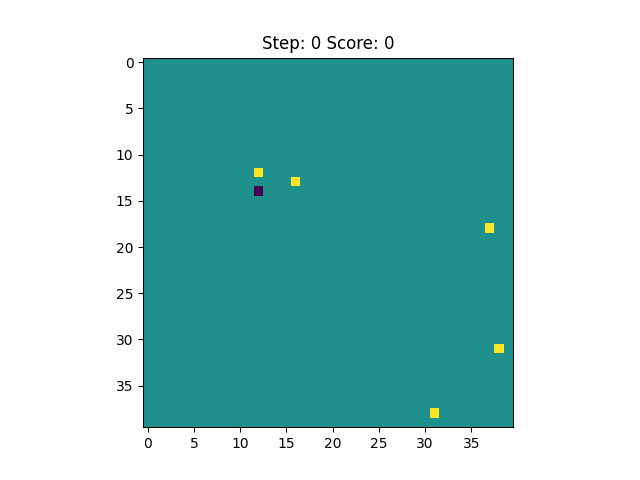

In [10]:
fig, ax = plt.subplots()
model.eval()
environment = WormEnvironment(grid_size, num_pellets, model)

def animate(i):
    ax.clear()
    position, pellets, score = environment.update()
    grid = environment.draw()
    ax.imshow(grid, cmap='viridis')
    ax.set_title(f'Step: {i} Score: {score}')
    return ax

ani = animation.FuncAnimation(fig, animate, frames=simulate_frames, interval=100, blit=False, repeat=False)

ani.save('NeuralController.gif', writer='pillow', fps=10)
plt.close(fig)
Image(filename='NeuralController.gif')

In [11]:
import numpy as np

class QLearningController:
    def __init__(self, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.q_table = {}  # Maps state to action values: state -> [action_values]
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon

    def decide_move(self, local_gradient):
        state = self._gradient_to_state(local_gradient)
        if state not in self.q_table:
            self.q_table[state] = np.zeros(4)  # Assuming 4 possible actions (up, down, left, right)

        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            action = np.random.choice(4)  # Explore
        else:
            action = np.argmax(self.q_table[state])  # Exploit

        return action

    def learn(self, current_state, action, reward, next_state):
        current_state = self._gradient_to_state(current_state)
        next_state = self._gradient_to_state(next_state)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(4)

        # Q-learning update rule
        td_target = reward + self.discount_factor * np.max(self.q_table[next_state])
        td_error = td_target - self.q_table[current_state][action]
        self.q_table[current_state][action] += self.learning_rate * td_error

    def _gradient_to_state(self, local_gradient):
        # This method should convert the local gradient into a discrete state representation.
        # Implementation depends on how you define your states based on the gradient.
        return tuple(local_gradient)